In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [28]:
# Using GPU if available
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

In [29]:
# Defining Constants
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.001
INPUT_SIZE = 28 * 28
HIDDEN_SIZE = [512,]
OUTPUT_SIZE = 10
CHECKPOINT_PATH = "./checkpoints"
LOG_DIR = "./logs"

In [30]:
# Creating Directories if not exists
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [31]:
# Tensorboard Writer
writer_train = SummaryWriter(log_dir=LOG_DIR+"/train")
writer_test = SummaryWriter(log_dir=LOG_DIR+"/test")

In [32]:
# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
# Model Definition
class MLP(nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[0], output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

In [34]:
# Model Initialization
model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)

In [35]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [36]:
# Checkpoint Backup

def save_checkpoints(epoch, model, optimizer, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_checkpoint(path):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"Resuming from epoch {start_epoch}...")
        return start_epoch
    return 1 # Start from Epoch 1

In [37]:
# Model evaluation
def evaluate_model(model, test_loader, criterion):

    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.view(-1, INPUT_SIZE).to(device), target.to(device)
            output = model(data)

            total_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        return 100 * correct / total, total_loss / len(test_loader)

In [38]:
# Updating tensorboard
def plot_tensorboard(writer, epoch, loss, accuracy):
    writer.add_scalar("Accuracy", accuracy, epoch)
    writer.add_scalar("Loss", loss, epoch)

In [39]:
# Training Loop
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs, device, checkpoint_path, resume=False):
    # model.train()
    
    if resume:
        if checkpoint_path is None:
            print("Checkpoint Path is required for resuming the training")
            return
        start_epoch = load_checkpoint(os.path.join(checkpoint_path, "mlp_checkpoint.pth"))
    else:
        start_epoch = 1

    for epoch in range(start_epoch, epochs + 1):

        total_loss = 0
        total_train = 0
        correct_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):

            model.train()
            
            data, target = data.reshape(-1, INPUT_SIZE).to(device), target.to(device)

            optimizer.zero_grad()

            output= model(data)
            
            loss = criterion(output, target)
            total_loss += loss.item()

            loss.backward()

            optimizer.step()

            _, predicted = torch.max(output, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
        
        train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        test_accuracy, test_loss = evaluate_model(model, test_loader, criterion)

        plot_tensorboard(writer_train, epoch, train_loss, train_accuracy)
        plot_tensorboard(writer_test, epoch, test_loss, test_accuracy)

        print(f"Epoch {epoch}/{epochs} : Train Loss {train_loss:.4f}, Train Accuracy {train_accuracy:.2f}%, Test Loss {test_loss:.4f}, Test Accuracy {test_accuracy:.2f}%")

        save_checkpoints(epoch, model,optimizer, os.path.join(checkpoint_path, "mlp_checkpoint.pth"))


In [40]:
train_model(model, criterion, optimizer, train_loader, test_loader, EPOCHS, device, CHECKPOINT_PATH)
writer_train.close()
writer_test.close()

Epoch 1/20 : Train Loss 1.6162, Train Accuracy 86.12%, Test Loss 1.5559, Test Accuracy 91.08%
Epoch 2/20 : Train Loss 1.5450, Train Accuracy 92.16%, Test Loss 1.5252, Test Accuracy 93.92%
Epoch 3/20 : Train Loss 1.5260, Train Accuracy 93.88%, Test Loss 1.5162, Test Accuracy 94.76%
Epoch 4/20 : Train Loss 1.5146, Train Accuracy 95.01%, Test Loss 1.5127, Test Accuracy 95.00%
Epoch 5/20 : Train Loss 1.5089, Train Accuracy 95.50%, Test Loss 1.4994, Test Accuracy 96.39%
Epoch 6/20 : Train Loss 1.5045, Train Accuracy 95.91%, Test Loss 1.4974, Test Accuracy 96.50%
Epoch 7/20 : Train Loss 1.5021, Train Accuracy 96.08%, Test Loss 1.4992, Test Accuracy 96.34%
Epoch 8/20 : Train Loss 1.4991, Train Accuracy 96.41%, Test Loss 1.4946, Test Accuracy 96.68%
Epoch 9/20 : Train Loss 1.4960, Train Accuracy 96.69%, Test Loss 1.5009, Test Accuracy 96.11%
Epoch 10/20 : Train Loss 1.4950, Train Accuracy 96.76%, Test Loss 1.4927, Test Accuracy 96.90%
Epoch 11/20 : Train Loss 1.4921, Train Accuracy 97.01%, Tes

In [41]:
def show_wrong_preds(model, test_loader, num=5):
    model.eval()
    with torch.no_grad():
        count = 0
        for data in test_loader:
            images, labels = data
            for i in range(64):
                img = images[i].view(-1, INPUT_SIZE).to(device)
                output = model(img)
                _, predicted = torch.max(output, 1)
                if predicted.item() != labels[i].item():
                    count += 1
                    plt.imshow(images[i].squeeze(), cmap="gray")
                    plt.show()
                    print(f"Example {count} - Predicted: {predicted.item()}, Actual: {labels[i].item()}")
                    if count >= num:
                        return

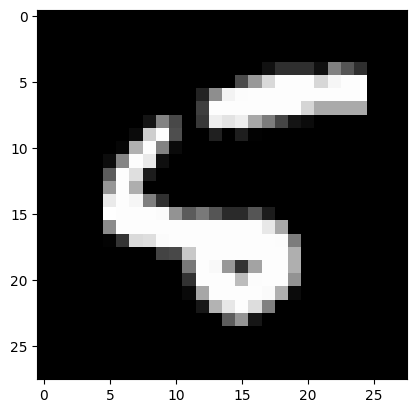

Example 1 - Predicted: 6, Actual: 5


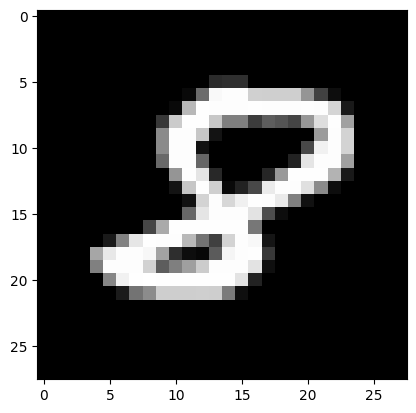

Example 2 - Predicted: 2, Actual: 8


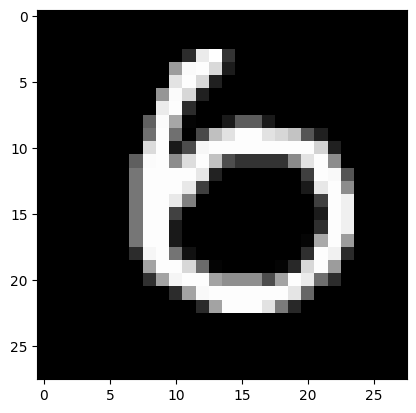

Example 3 - Predicted: 0, Actual: 6


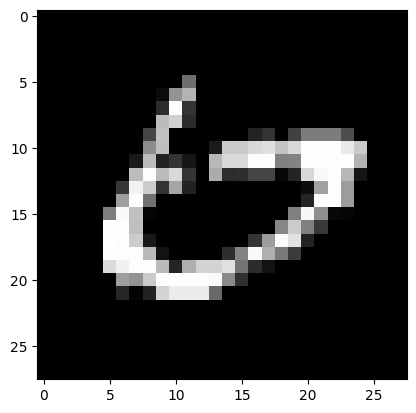

Example 4 - Predicted: 0, Actual: 6


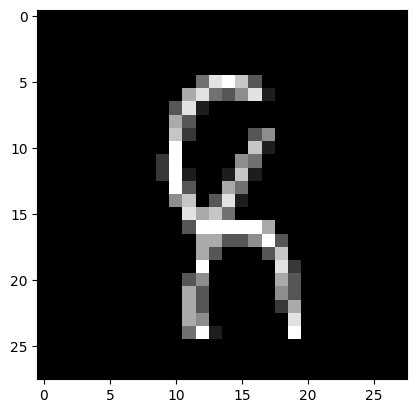

Example 5 - Predicted: 5, Actual: 8


In [42]:
show_wrong_preds(model, test_loader, 5)

In [43]:
# Fetching the predictions
def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, INPUT_SIZE)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Plot confusion matrix
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10,))
    disp.plot(cmap='inferno')
    plt.title(title)
    plt.show()

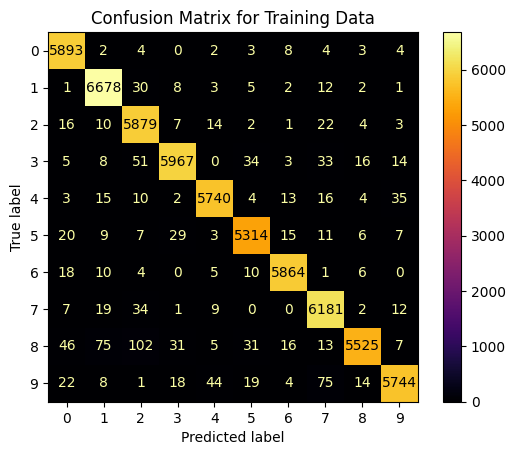

In [45]:
# Plotting CM for Training Data
train_labels, train_preds = get_all_predictions(model, train_loader, device)
plot_confusion_matrix(train_labels, train_preds, "Confusion Matrix for Training Data")

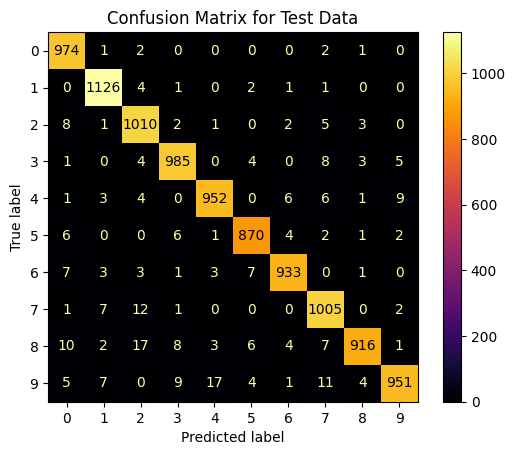

In [46]:
# Plotting CM for Test Data
test_labels, test_preds = get_all_predictions(model, test_loader, device)
plot_confusion_matrix(test_labels, test_preds, "Confusion Matrix for Test Data")